# Structural Variant analysis

Structural Variant analysis was performed using Manta and Delly. The data generation is detailed below.

## Structural Variant calling with Delly

`Delly version: v0.8.2
 using Boost: v1.70.0
 using HTSlib: v1.9`
 
We follow the delly github steps (call, sites.bcf, joint genotype calling)
`bcftools view merged.bcf | grep -c -v '^#'`

### Initial calls
We follow germline SV calling instructions on https://github.com/dellytools/delly.
To parallelize on HPC, we utilize IBM's LSF scheduler. Individual jobs are:
`delly call -g ucsc.hg19.fasta -x excludeTemplates/human.hg19.excl.tsv -o ${DellyDir}/${LSB_JOBINDEX}.bcf ${GATKDir}/${LSB_JOBINDEX}/Alignment/${LSB_JOBINDEX}_1_FR_hg19.paired_aligned_Sorted_Merged_dedup.bam`
where LSB_JOBINDEX iterates (in parallel) over the sample identifiers.

### Merge of calls
`cd ${DellyDir}`
`delly merge -o sites117.bcf *bcf`

### Joint Genotype calling 
This step is very similar to the initial calls, but with additional site information.
`delly call -g ucsc.hg19.fasta -v sites117.bcf -x delly/excludeTemplates/human.hg19.excl.tsv -o /research/genomicds1/Manta/Delly/${LSB_JOBINDEX}.geno.bcf ${LSB_JOBINDEX}_001_FR_hg19.paired_aligned_Sorted_Merged_dedup.bam`


### Merging and filtering  all genotyped Delly files
`bcftools merge -m id -O b -o merged.bcf *.geno.bcf`

`delly filter -f germline -o mergedFiltered.bcf merged.bcf` 

`bcftools view mergedFiltered.bcf | grep -c -v '^#'`
25830

We then remove low quality calls using the python script removeLowQual.py
`python removeLowQual.py > mergedFilteredPASS.vcf`
`grep -v "^#" mergedFilteredPASS.vcf |cut -d$'\t' -f5,7|grep PASS|grep '^<' |sort |uniq -c`


`  14134 <DEL>	PASS
   1879 <DUP>	PASS
    241 <INS>	PASS
   1766 <INV>	PASS`

## Structural Variant calling with Manta
We follow default settings  
The python script createWorkflows.py runs configManta for each sample. We use manta version 1.6.0 (through bioconda).
`configManta.py --bam %s --referenceFasta %s  --runDir %s" %(bamfile, REFGENOME, sampleDir)`
It also prepares the job submission script, which runs Manta's runWorkflow.py for each sample (see MantaDir/bsub*.sh).


## Consensus callsets with Survivor
Using  version 1.0.6, we follow the instructions provided on:

https://github.com/fritzsedlazeck/SURVIVOR/wiki
#### Merging across SV-callers (by individual)
The previous steps generated 2x117 call sets. We first merge across SV callers, see survivorMergePrep.py (decompresses Manta calls, prepares samplefiles, submits jobs). For each sample:
`SURVIVOR merge {sampleFilename} 1000 1 1 1 0 50 {datadir}/mergeMantaDelly_{sample}_1.vcf`

### Merging across individuals
To explore the impact of union vs intersection of the callsets, we call Survivor respectively:

#### For union of calls
`
SURVIVOR merge mergeMantaDellyAll_1.txt 1000 50 1 1 0 50 mergeMantaDellyAll_50_1.vcf
SURVIVOR merge mergeMantaDellyAll_1.txt 1000 5 1 1 0 50 mergeMantaDellyAll_5_1.vcf`

#### For intersection of calls
`SURVIVOR merge mergeMantaDellyAll_2.txt 1000 50 1 1 0 50 mergeMantaDellyAll_50_2.vcf
SURVIVOR merge mergeMantaDellyAll_2.txt 1000 5 1 1 0 50 mergeMantaDellyAll_5_2.vcf`

As expected, union callsets (are substantially larger than intersection call sets. The further usage depends on prioritizing recall vs. precision, respectively. 

`grep -c -v '^#' mergeMantaDellyAll_*vcf
mergeMantaDellyAll_50_1.vcf:35934
mergeMantaDellyAll_50_2.vcf:1205
mergeMantaDellyAll_5_1.vcf:79351
mergeMantaDellyAll_5_2.vcf:4519
mergeMantaDellyAll_60_2.vcf:907
mergeMantaDellyAll_60.vcf:32317`

## Annotation of Structural Variants using AnnotSV

We run SV annotation for individual Survivor files:
### AC>=50, double confirmed (intersection callsets)
`${AnnotSV}/AnnotSV.tcl -SVinputFile ${SurvivorDir}/mergeMantaDellyAll_50_2.vcf -SVinputInfo 1  -overlap 70 -SVminSize 50 -outputFile ./annotated_MantaDelly_50_2.tsv`
### AC>=5, double confirmed
`${AnnotSV}/AnnotSV.tcl -SVinputFile ${SurvivorDir}/mergeMantaDellyAll_5_2.vcf -SVinputInfo 1  -overlap 70 -SVminSize 50 -outputFile ./annotated_MantaDelly_5_2.tsv`
Analogously, we annotate union callsets, yielding `annotated_MantaDelly_*_1.tsv`.
### AC>=1, double confirmed
`${AnnotSV}/AnnotSV.tcl -SVinputFile ${SurvivorDir}/mergeMantaDellyAll_1_2.vcf -SVinputInfo 1  -overlap 70 -SVminSize 50 -outputFile ./annotated_MantaDelly_1_2.tsv`
Analogously, we annotate union callsets, yielding `annotated_MantaDelly_*_1.tsv`.


In [1]:
import pandas as pd
from IPython.display import display
from collections import Counter
#from matplotlib import rc

import matplotlib.pyplot as plt
import numpy as np

# SV Evaluation
## Dominant SVs (AC>50), double called (Manta+Delly)


In [240]:
df = pd.read_csv('annotated_MantaDelly_new.tsv', sep='\t')
pd.options.display.max_columns = 35
display(df.head())

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_mode,DDD_consequence,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking
0,1_869397_870269_DEL,1,869397,870269,-810,DEL,MantaDEL:39:0:1:0:0:0,G,<DEL>,830,PASS,SUPP=53;SUPP_VEC=00000000000000110001000010111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,75.37,-3.083735,-3.775541,2.289318e-08,-1.302316,-2.531252,-2.471628,NaN,NaN,NaN,NaN,NaN,1
1,1_869397_870269_DEL,1,869397,870269,-810,DEL,MantaDEL:39:0:1:0:0:0,G,<DEL>,830,PASS,SUPP=53;SUPP_VEC=00000000000000110001000010111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,75.37,-3.083735,-3.775541,2.289318e-08,-1.302316,-2.531252,-2.471628,NaN,NaN,NaN,NaN,NaN,1
2,1_1649117_1650494_DEL,1,1649117,1650494,-1084,DEL,DEL00000075,C,<DEL>,999,PASS,SUPP=89;SUPP_VEC=01100011000111100011100111011...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:982:0,0:+-:766:DEL:DEL00000075:NA:NA:ch...","0/1:11:982:0,0:+-:999:DEL:DEL00000075:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,71.07,0.624346,4.560961,8.892033e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1_1649117_1650494_DEL,1,1649117,1650494,-1084,DEL,DEL00000075,C,<DEL>,999,PASS,SUPP=89;SUPP_VEC=01100011000111100011100111011...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:982:0,0:+-:766:DEL:DEL00000075:NA:NA:ch...","0/1:11:982:0,0:+-:999:DEL:DEL00000075:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,71.07,0.624346,-0.019426,2.648106e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1_1649117_1650494_DEL,1,1649117,1650494,-1084,DEL,DEL00000075,C,<DEL>,999,PASS,SUPP=89;SUPP_VEC=01100011000111100011100111011...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:982:0,0:+-:766:DEL:DEL00000075:NA:NA:ch...","0/1:11:982:0,0:+-:999:DEL:DEL00000075:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,67.44,0.573438,4.560961,8.892033e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [239]:
## Calculate AF (note: ./. is interpreted as SV absent!)
gtDict = {'./.':0, '0/0':0,'0/1':1, '1/1':2}
def allelFreq(row):
    gtScores = [gtDict.get(gt.split(':')[0], None) for gt in list(row)[13:129]]
    gtScores = [gt for gt in gtScores if not gt is None]
    AC = sum(gtScores)
    AF = AC/(2*len(gtScores)) if gtScores else np.nan
    return (AC, AF)
df['AC'], df['AF'] = zip(*[allelFreq(row) for idx, row in df.iterrows()])
df.sort_values(by='AF', ascending=False)

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
106,1_156526704_156528935_DEL,1,156526704,156528935,-2221,DEL,MantaDEL:10485:0:1:0:0:0,T,<DEL>,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:2221:0,0:+-:999:DEL:MantaDEL:10829:0:1:...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:6710:0:1:0...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:11916:0:1:...","1/1:11:2221:0,0:+-:731:DEL:MantaDEL:6161:0:1:0...",...,NaN,NaN,51.29,0.247546,-0.332180,3.312007e-14,-2.623544,-0.510932,-1.402031,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
107,1_156526704_156528935_DEL,1,156526704,156528935,-2221,DEL,MantaDEL:10485:0:1:0:0:0,T,<DEL>,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:2221:0,0:+-:999:DEL:MantaDEL:10829:0:1:...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:6710:0:1:0...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:11916:0:1:...","1/1:11:2221:0,0:+-:731:DEL:MantaDEL:6161:0:1:0...",...,NaN,NaN,51.29,0.247546,-0.332180,3.312007e-14,-2.623544,-0.510932,-1.402031,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
115,1_176478217_176478773_DEL,1,176478217,176478773,-539,DEL,MantaDEL:11882:0:1:0:0:0,TAAGTAGAGAATATGTGATGCACTATTTAATCAGAGGTCAGATGAG...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:539:0,0:+-:999:DEL:MantaDEL:12297:0:1:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:7624:0:0:0:...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:13595:0:0:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:6970:0:0:0:...",...,NaN,NaN,46.27,0.443411,0.299864,1.083788e-03,-0.121360,1.453434,0.877118,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
116,1_176478217_176478773_DEL,1,176478217,176478773,-539,DEL,MantaDEL:11882:0:1:0:0:0,TAAGTAGAGAATATGTGATGCACTATTTAATCAGAGGTCAGATGAG...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:539:0,0:+-:999:DEL:MantaDEL:12297:0:1:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:7624:0:0:0:...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:13595:0:0:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:6970:0:0:0:...",...,NaN,NaN,46.27,0.443411,0.299864,1.083788e-03,-0.121360,1.453434,0.877118,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
142,1_224247102_224247578_DEL,1,224247102,224247578,-469,DEL,MantaDEL:7897:1:1:0:0:0,TTAAATTAAGGGCCTTAAAAAAAAAAAAAAAAAAAAAAGAGAGACA...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:469:0,0:+-:999:DEL:MantaDEL:15952:0:1:0...","1/1:11:469:0,0:+-:819:DEL:MantaDEL:9922:0:0:0:...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:17616:0:0:0...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:8971:0:1:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,1_46365900_46366437_DEL,1,46365900,46366437,-433,DEL,DEL00001068,A,<DEL>,999,PASS,SUPP=50;SUPP_VEC=11010010111001011101110001100...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"0/1:11:433:0,0:+-:599:DEL:DEL00001068:NA:NA:ch...","0/1:11:433:0,0:+-:919:DEL:DEL00001068:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:433:0,0:+-:999:DEL:DEL00001068:NA:NA:ch...",...,NaN,NaN,44.29,-1.565927,1.220012,9.384739e-10,0.786044,-2.531252,-2.471628,NaN,NaN,NaN,NaN,NaN,2,49,0.211207
1645,8_6790597_6791193_DEL,8,6790597,6791193,-459,DEL,DEL00028977,G,<DEL>,999,PASS,SUPP=50;SUPP_VEC=01100101110001100100001100110...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:459:0,0:+-:999:DEL:DEL00028977:NA:NA:ch...","0/1:11:459:0,0:+-:999:DEL:DEL00028977:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,49

(8, 54, 146, 163, 1459)

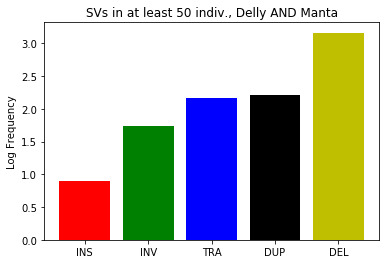

In [209]:
#rc('text', usetex=True)
svtype, freq = zip(*sorted(Counter(df['SV type']).items(), key=lambda x:x[1]))
xpos = range(len(svtype))
plt.bar(xpos, np.log10(freq), align='center', color='rgbky')
plt.xticks(xpos, svtype)
plt.ylabel('Log Frequency')
plt.title('SVs in at least 50 indiv., Delly AND Manta')
freq

(array([1., 1., 0., 0., 0., 0., 2., 0., 2., 2.]),
 array([54. , 55.2, 56.4, 57.6, 58.8, 60. , 61.2, 62.4, 63.6, 64.8, 66. ]),
 <a list of 10 Patch objects>)

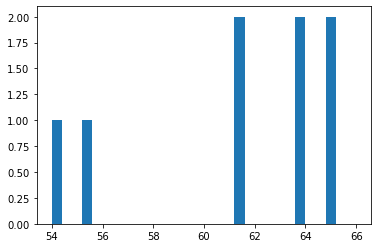

In [210]:
insSV = df[(df['SV type']=='INS')  ]
plt.hist(insSV['SV length'], width=0.4)


In [211]:
Counter(df.DDD_disease).most_common(10)

[(nan, 1777),
 ('AUTOSOMAL RECESSIVE MENTAL RETARDATION', 3),
 ('MENTAL RETARDATION-STEREOTYPIC MOVEMENTS-EPILEPSY AND/OR CEREBRAL MALFORMATIONS',
  2),
 ('EPILEPTIC ENCEPHALOPATHY, EARLY INFANTILE, 23', 1),
 ('NONSYNDROMIC AUTOSOMAL-RECESSIVE INTELLECTUAL DISABILITY', 1),
 ('COENZYME Q10 DEFICIENCY, PRIMARY, 2', 1),
 ('GENERALIZED EPILEPSY AND PAROXYSMAL DYSKINESIA', 1),
 ('MENTAL RETARDATION, AUTOSOMAL DOMINANT 24/Autism, intellectual disability, basal ganglia dysfunction and epilepsy',
  1),
 ('POTOCKI-SHAFFER SYNDROME', 1),
 ('MENTAL RETARDATION AUTOSOMAL DOMINANT TYPE 4', 1)]

In [212]:
df[df['SV type'] == 'INS']

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
715,18_3016163_3016164_INS,18,3016163,3016164,54,INS,MantaINS:159927:0:0:0:0:0,GG,GTCACTCCTGCTCTAGCTCTCTGCAGAGCTACTCTATTGGCCACTT...,999,PASS,SUPP=108;SUPP_VEC=1111111111111111110111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:54:0,0:+-:999:INS:MantaINS:193480:0:0:0...","1/1:11:54:0,0:+-:992:INS:MantaINS:123100:0:0:0...","1/1:11:54:0,0:+-:999:INS:MantaINS:214674:0:0:0...","1/1:11:54:0,0:+-:616:INS:MantaINS:111223:0:0:0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,170,0.732759
1054,22_18394639_18394640_INS,22,18394639,18394640,62,INS,MantaINS:221544:0:0:0:0:0,GA,GCTTTGGAATGCCATCAGGAGGAAGCTTAGATGAAAAATGCACTAT...,999,PASS,SUPP=54;SUPP_VEC=11011110000100011000101100100...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"0/1:11:62:0,0:+-:534:INS:MantaINS:213293:0:0:0...","0/1:11:62:0,0:+-:999:INS:MantaINS:135667:0:0:0...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:62:0,0:+-:587:INS:MantaINS:123036:0:0:0...",...,NaN,NaN,36.04,-0.452740,0.723470,9.999972e-01,-2.286440,-2.026546,-2.012633,NaN,NaN,NaN,NaN,NaN,2,64,0.275862
1055,22_18394639_18394640_INS,22,18394639,18394640,62,INS,MantaINS:221544:0:0:0:0:0,GA,GCTTTGGAATGCCATCAGGAGGAAGCTTAGATGAAAAATGCACTAT...,999,PASS,SUPP=54;SUPP_VEC=11011110000100011000101100100...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"0/1:11:62:0,0:+-:534:INS:MantaINS:213293:0:0:0...","0/1:11:62:0,0:+-:999:INS:MantaINS:135667:0:0:0...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:62:0,0:+-:587:INS:MantaINS:123036:0:0:0...",...,NaN,NaN,36.04,-0.452740,0.723470,9.999972e-01,-2.286440,-2.026546,-2.012633,NaN,NaN,NaN,NaN,NaN,2,64,0.275862
1190,4_40754838_40754839_INS,4,40754838,40754839,66,INS,MantaINS:43220:0:0:0:0:0,AG,ATAATGTAGCTTAACTCTGAAGCCAGCAATTTGTCATGGAGAAAAA...,999,PASS,SUPP=114;SUPP_VEC=1111111111011111111111111101...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:66:0,0:+-:999:INS:MantaINS:55331:0:0:0:...","1/1:11:66:0,0:+-:999:INS:MantaINS:32553:0:0:0:...","0/1:11:66:0,0:+-:938:INS:MantaINS:61337:0:0:0:...","1/1:11:66:0,0:+-:999:INS:MantaINS:31140:0:0:0:...",...,NaN,NaN,60.79,1.326433,-0.354414,1.228129e-01,0.218965,-1.925715,-1.382591,NaN,NaN,NaN,NaN,NaN,2,193,0.831897
1191,4_40754838_40754839_INS,4,40754838,40754839,66,INS,MantaINS:43220:0:0:0:0:0,AG,ATAATGTAGCTTAACTCTGAAGCCAGCAATTTGTCATGGAGAAAAA...,999,PASS,SUPP=114;SUPP_VEC=1111111111011111111111111101...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:66:0,0:+-:999:INS:MantaINS:55331:0:0:0:...","1/1:11:66:0,0:+-:999:INS:MantaINS:32553:0:0:0:...","0/1:11:66:0,0:+-:938:INS:MantaINS:61337:0:0:0:...","1/1:11:66:0,0:+-:999:INS:MantaINS:31140:0:0:0:...",...,NaN,NaN,60.79,1.326433,-0.354414,1.228129e-01,0.218965,-1.925715,-1.382591,NaN,NaN,NaN,NaN,NaN,2,193,0.831897
1398,5_177885167_177885168_INS,5,177885167,177885168,64,INS,MantaINS:65490:0:0:0:0:0,CC,CTGAAATACATTAAACAGGTTTAAATATGTGAGGTCATAATGGTAC...,999,PASS,SUPP=113;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:64:0,0:+-:999:INS:MantaINS:79779:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:50268:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:88753:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:45159:0:0:0:...",...,NaN,NaN,65.58,-0.940991,-0.137669,2.151765e-10,1.540617,0.976320,1.232487,NaN,NaN,NaN,NaN,NaN,2,184,0.793103
1399,5_177885167_177885168_INS,5,177885167,177885168,64,INS,MantaINS:65490:0:0:0:0:0,CC,CTGAAATACATTAAACAGGTTTAAATATGTGAGGTCATAATGGTAC...,999,PASS,SUPP=113;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:64:0,0:+-:999:INS:MantaINS:79779:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:50268:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:88753:0:0:0:...","1/1:11:64:0,0:+-:999:INS:MantaINS:45159:0:0:0:...",

In [235]:
Counter(df.Phenotypes).most_common(10)
co = cols[1:5]+cols[8:9] + cols[-5:] + [c for c in cols if c.startswith('DDD') or c.startswith('DGV')]
type(df.iloc[0]['Phenotypes'])
df[co]

,SV chrom,SV start,SV end,SV length,Gene name,Phenotypes,Inheritance,AnnotSV ranking,AC,AF,DGV_GAIN_IDs,DGV_GAIN_n_samples_with_SV,DGV_GAIN_n_samples_tested,DGV_GAIN_Frequency,DGV_LOSS_IDs,DGV_LOSS_n_samples_with_SV,DGV_LOSS_n_samples_tested,DGV_LOSS_Frequency,DDD_SV,DDD_DUP_n_samples_with_SV,DDD_DUP_Frequency,DDD_DEL_n_samples_with_SV,DDD_DEL_Frequency,DDD_status,DDD_mode,DDD_consequence,DDD_disease,DDD_pmids
0,1,869397,870269,-810,SAMD11,NaN,NaN,1,79,0.340517,"gssvG1,gssvG5,gssvG149",135,20796,0.006492,"gssvL6,gssvL56,gssvL70",348,9142,0.038066,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN
1,1,869397,870269,-810,SAMD11,NaN,NaN,1,79,0.340517,"gssvG1,gssvG5,gssvG149",135,20796,0.006492,"gssvL6,gssvL56,gssvL70",348,9142,0.038066,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN
2,1,1649117,1650494,-1084,CDK11A/CDK11B,NaN,NaN,1,88,0.379310,"gssvG1,gssvG12,gssvG20,gssvG40,gssvG34",100,24444,0.004091,"gssvL99,gssvL102,gssvL109,gssvL103,gssvL110,gs...",592,26344,0.022472,1:1573839-1674143;1:1625694-1678590;1:1640686-...,17.0,0.020118,41.0,0.048521,NaN,NaN,NaN,NaN,NaN
3,1,1649117,1650494,-1084,CDK11A,NaN,NaN,1,88,0.379310,"gssvG1,gssvG12,gssvG20,gssvG40,gssvG34",100,24444,0.004091,"gssvL99,gssvL102,gssvL109,gssvL103,gssvL110,gs...",592,26344,0.022472,1:1573839-1674143;1:1625694-1678590;1:1640686-...,17.0,0.020118,41.0,0.048521,NaN,NaN,NaN,NaN,NaN
4,1,1649117,1650494,-1084,CDK11B,NaN,NaN,1,88,0.379310,"gssvG1,gssvG12,gssvG20,gssvG40,gssvG34",100,24444,0.004091,"gssvL99,gssvL102,gssvL109,gssvL103,gssvL110,gs...",592,26344,0.022472,1:1573839-1674143;1:1625694-1678590;1:1640686-...,17.0,0.020118,41.0,0.048521,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,Y,14172701,14172702,0,NaN,NaN,NaN,2,87,0.375000,NaN,0,0,-1.000000,NaN,0,0,-1.000000,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN
1826,Y,16642969,16642970,0,NLGN4Y,NaN,NaN,2,51,0.219828,NaN,0,0,-1.000000,NaN,0,0,-1.000000,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN
1827,Y,16642969,16642970,0,NLGN4Y,NaN,NaN,2,51,0.219828,NaN,0,0,-1.000000,NaN,0,0,-1.000000,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN
1828,Y,22259180,22269287,9964,NaN,NaN,NaN,2,65,0.280172,NaN,0,0,-1.000000,"gssvL138379,gssvL138390",42,1738,0.024166,NaN,NaN,-1.000000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN


In [236]:
df.shape


(1830, 200)

## Common Structural variants (AC>5), confirmed by both Delly and Manta
After calling Delly and Manta SVs and merging with Survivor, we explore SVs (allele frequencies etc.) for  

In [242]:
isecCallset5 = pd.read_csv('annotated_MantaDelly_5_2.tsv', sep='\t')
isecCallset5['AC'], isecCallset5['AF'] = zip(*[allelFreq(row) for idx, row in isecCallset5.iterrows()]) # 
isecCallset5.sort_values(by=['AF'], ascending=False)  #sorting by allele frequency 

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
322,1_156526704_156528935_DEL,1,156526704,156528935,-2221,DEL,MantaDEL:10485:0:1:0:0:0,T,<DEL>,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:2221:0,0:+-:999:DEL:MantaDEL:10829:0:1:...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:6710:0:1:0...","1/1:11:2221:0,0:+-:999:DEL:MantaDEL:11916:0:1:...","1/1:11:2221:0,0:+-:731:DEL:MantaDEL:6161:0:1:0...",...,NaN,NaN,51.29,0.247546,-0.332180,3.312007e-14,-2.623544,-0.510932,-1.402031,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
355,1_176478217_176478773_DEL,1,176478217,176478773,-539,DEL,MantaDEL:11882:0:1:0:0:0,TAAGTAGAGAATATGTGATGCACTATTTAATCAGAGGTCAGATGAG...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:539:0,0:+-:999:DEL:MantaDEL:12297:0:1:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:7624:0:0:0:...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:13595:0:0:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:6970:0:0:0:...",...,NaN,NaN,46.27,0.443411,0.299864,1.083788e-03,-0.121360,1.453434,0.877118,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
420,1_224247102_224247578_DEL,1,224247102,224247578,-469,DEL,MantaDEL:7897:1:1:0:0:0,TTAAATTAAGGGCCTTAAAAAAAAAAAAAAAAAAAAAAGAGAGACA...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:469:0,0:+-:999:DEL:MantaDEL:15952:0:1:0...","1/1:11:469:0,0:+-:819:DEL:MantaDEL:9922:0:0:0:...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:17616:0:0:0...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:8971:0:1:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,232,1.000000
6905,X_7623887_7673828_DEL,X,7623887,7673828,-49988,DEL,MantaDEL:204584:0:1:0:0:0,N,<DEL>,996,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:49978:0,0:+-:435:DEL:MantaDEL:216696:0:...","1/1:11:49979:0,0:+-:992:DEL:MantaDEL:137633:0:...","1/1:11:49968:0,0:+-:171:DEL:MantaDEL:240556:0:...","1/1:11:50019:0,0:+-:266:DEL:MantaDEL:125154:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,232,1.000000
3683,2_208567051_208567555_DEL,2,208567051,208567555,-405,DEL,DEL00006757,C,<DEL>,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:744:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,232,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3443,2_37347627_37348361_DEL,2,37347627,37348361,-725,DEL,MantaDEL:17693:0:1:0:0:0,G,<DEL>,398,PASS,SUPP=5;SUPP_VEC=000000000000000000100000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,89.74,-0.397910,0.908498,1.085594e-01,-0.216459,0.086765,0.015134,NaN,NaN,NaN,NaN,NaN,1,4,0.017241
1919,14_104767033_104767735_DEL,14,104767033,104767735,-579,DEL,DEL00056319,T,<DEL>,847,PASS,SUPP=5;SUPP_VEC=000000000000000110000000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,0.017241
1470,12_125427127_125427128_TRA,12,125427127,125427128,0,TRA,MantaBND:119305:0:1:0:0:0:0,N,N[chr10:32320744[,61,PASS,SUPP=5;SUPP_VEC=000000000000000000

In [243]:
isecCallset5.shape

(7149, 200)

## Distribution of SV lengths by SV type
### Deletions

(array([33,  0, 10,  4,  0,  0,  0, 21, 19, 24,  0,  0,  3, 27, 18, 24, 25,
        39, 85]), array([-957508.        , -909744.42105263, -861980.84210526,
        -814217.26315789, -766453.68421053, -718690.10526316,
        -670926.52631579, -623162.94736842, -575399.36842105,
        -527635.78947368, -479872.21052632, -432108.63157895,
        -384345.05263158, -336581.47368421, -288817.89473684,
        -241054.31578947, -193290.73684211, -145527.15789474,
         -97763.57894737,  -50000.        ]), array([5.98114241, 5.9589194 , 5.93549761, 5.91074031, 5.88448592,
        5.85654167, 5.82667496, 5.79460162, 5.75996938, 5.72233425,
        5.6811256 , 5.63559294, 5.5847213 , 5.52709021, 5.4606241 ,
        5.38211491, 5.28621104, 5.16294405, 4.99017709, 4.69897   ]))

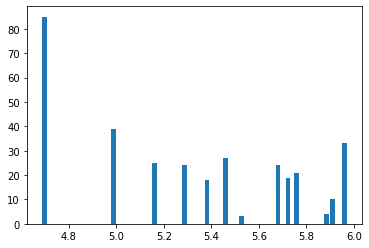

In [215]:
minLen = 50000 ## filtering out short deletions, else every other number is dwarfed
delSV = isecCallset5[(isecCallset5['SV type']=='DEL') & (isecCallset5['SV length']<-minLen) ]

bins=np.linspace(min(delSV['SV length']), -minLen , 20)
freqs, lenbins = np.histogram(delSV['SV length'], bins=bins)
len(freqs), len(lenbins)
_ = plt.bar(np.log10(-lenbins)[1:], freqs, width=0.02, align='center')
freqs, lenbins, np.log10(-lenbins)
#plt.ylabel('Log10 Frequency')
#plt.title('SVs in at least 50 indiv., Delly AND Manta')


In [216]:
np.linspace(min(delSV['SV length']), -1000 , 20)

array([-957508.        , -907165.47368421, -856822.94736842,
       -806480.42105263, -756137.89473684, -705795.36842105,
       -655452.84210526, -605110.31578947, -554767.78947368,
       -504425.26315789, -454082.73684211, -403740.21052632,
       -353397.68421053, -303055.15789474, -252712.63157895,
       -202370.10526316, -152027.57894737, -101685.05263158,
        -51342.52631579,   -1000.        ])

In [217]:
bins


array([-957508.        , -909744.42105263, -861980.84210526,
       -814217.26315789, -766453.68421053, -718690.10526316,
       -670926.52631579, -623162.94736842, -575399.36842105,
       -527635.78947368, -479872.21052632, -432108.63157895,
       -384345.05263158, -336581.47368421, -288817.89473684,
       -241054.31578947, -193290.73684211, -145527.15789474,
        -97763.57894737,  -50000.        ])

(array([1., 1., 2., 0., 0., 2., 1., 2., 2., 2.]),
 array([54. , 55.4, 56.8, 58.2, 59.6, 61. , 62.4, 63.8, 65.2, 66.6, 68. ]),
 <a list of 10 Patch objects>)

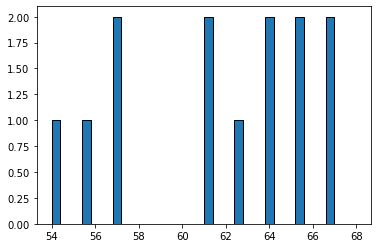

In [218]:
insSV = isecCallset5[(isecCallset5['SV type']=='INS')  ]
#bins=np.linspace(min(delSV['SV length']), -minLen , 20)
plt.hist(insSV['SV length'], width=0.4, edgecolor='k')

#plt.ylabel('Log10 Frequency')
#plt.title('SVs in at least 50 indiv., Delly AND Manta')

In [219]:
lenbins

array([-957508.        , -909744.42105263, -861980.84210526,
       -814217.26315789, -766453.68421053, -718690.10526316,
       -670926.52631579, -623162.94736842, -575399.36842105,
       -527635.78947368, -479872.21052632, -432108.63157895,
       -384345.05263158, -336581.47368421, -288817.89473684,
       -241054.31578947, -193290.73684211, -145527.15789474,
        -97763.57894737,  -50000.        ])

## Allele Frequency distribution

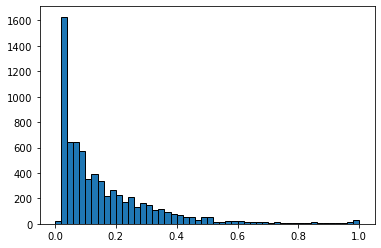

In [220]:
_=plt.hist(isecCallset5.AF, bins=np.linspace(0.00, 1, 51), edgecolor='black')

In [221]:
pd.DataFrame(Counter(isecCallset5.Phenotypes).most_common(10), columns = 'Phenotypes Freq'.split())

,Phenotypes,Freq
0,NaN,6671
1,"Thyroid dyshormonogenesis 2A, 274500 (3);Throm...",8
2,"Mental retardation, AD 33, 616311 (3)/ (Ventri...",7
3,"Spinocerebellar ataxia, AR 18, 616204 (3)",5
4,"Aortic aneurysm, familial thoracic 8, 615436 (3)",4
5,"Epileptic encephalopathy, early infantile, 28,...",4
6,"Retinitis pigmentosa 25, 602772 (3)",4
7,"(Coronary artery disease, susceptibility to) (...",4
8,"Diaphragmatic hernia 3, 610187 (3)/ Tetralogy ...",4
9,"(Hemolytic uremic syndrome, atypical, suscepti...",3


### Identification of common disease related SVs according to dbVar
We identify 10 disease related SVs according to dbVar (where status), and involved genes are identified. Allele frequencies vary between 3.0% and 11.6%.

In [ ]:
co = ['dbVar_status']+co
dbvar = isecCallset5[~isecCallset5['dbVar_status'].isnull()][co]
dbvar.sort_values('AF', ascending=False)

In [ ]:
dbvar.shape

In [ ]:
Counter(isecCallset5['Inheritance'])

In [ ]:
Counter(isecCallset5['dbVar_status'])

In [ ]:
dbvar = isecCallset5[isecCallset5['dbVar_status']!=np.nan]
cols = list(dbvar.columns.values[:7]) + list(dbvar.columns.values[-70:])
dbvar[cols]

## Consequential SVs (DDD Consequence)
We detect 213 consequential structural variants, of which, there are 107 confirmed cases (according to DDD status), 62 probable, 33 possible and 11 miscellaenous. Their allele frequencies range
{'confirmed/probable': 5,
             'probable': 62,
             'confirmed': 107,
             'possible': 33,
             'both DD and IF': 3,
             'confirmed/possible': 3})

In [227]:
pd.options.display.max_columns = None
isecCallset5['Cons'] = [type(el)==str for el in isecCallset5.DDD_consequence]
cons = isecCallset5[isecCallset5.Cons][cols]
print(cons.shape)
cons.sort_values(by='AF', ascending=False)
#isecCallset5[isecCallset5.DDD_consequence.str.contains('loss of function')]
#conseq = Counter(isecCallset5.DDD_consequence).most_common(20)
#cons.iloc[0]['DDD_consequence']==pd.nan


(213, 77)


,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,AnnotSV type,Gene name,NM,CDS length,tx length,location,location2,intersectStart,intersectEnd,DGV_GAIN_IDs,DGV_GAIN_n_samples_with_SV,DGV_GAIN_n_samples_tested,DGV_GAIN_Frequency,DGV_LOSS_IDs,DGV_LOSS_n_samples_with_SV,DGV_LOSS_n_samples_tested,DGV_LOSS_Frequency,GD_ID,GD_AN,GD_N_HET,GD_N_HOMALT,GD_AF,GD_POPMAX_AF,GD_ID_others,DDD_SV,DDD_DUP_n_samples_with_SV,DDD_DUP_Frequency,DDD_DEL_n_samples_with_SV,DDD_DEL_Frequency,1000g_event,1000g_AF,1000g_max_AF,IMH_ID,IMH_AF,IMH_ID_others,promoters,dbVar_event,dbVar_variant,dbVar_status,TADcoordinates,ENCODEexperiments,GCcontent_left,GCcontent_right,Repeats_coord_left,Repeats_type_left,Repeats_coord_right,Repeats_type_right,ACMG,HI_CGscore,TriS_CGscore,DDD_status,DDD_mode,DDD_consequence,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
6911,X_10738668_10788740_DEL,X,10738668,10788740,-50025,DEL,MantaDEL:234309:0:1:0:0:0,split,MID1,NM_033290,0.0,50073.0,intron1-intron1,5'UTR,10738668.0,10788740.0,NaN,0,0,-1.000000,gssvL135363,2,768,0.002604,NaN,NaN,NaN,NaN,-1,-1.000000,NaN,NaN,NaN,-1.000000,NaN,-1.000000,NaN,-1.000000,-1.0000,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,X:10760001-11240000,ENCFF032FMN:ENCFF701HCM:ENCFF935GWA:ENCFF996RJN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,confirmed,hemizygous,loss of function,"OPITZ G/BBB SYNDROME, X-LINKED",17221865;15558842;12545276,5.13,0.270383,3.021392,7.739847e-01,NaN,NaN,NaN,yes,NaN,300552,"Opitz GBBB syndrome, type I, 300000 (3)",XLR,4,228,0.982759
4714,4_79269120_79275195_DEL,4,79269120,79275195,-6068,DEL,MantaDEL:45446:0:1:0:0:0,split,FRAS1,NM_025074,0.0,6076.0,intron20-intron20,CDS,79269120.0,79275195.0,NaN,0,0,-1.000000,gssvL91357,92,877,0.104903,gnomAD_v2_DEL_4_55039,21476,1,0,4.70000013592653e-05,0.000132,gnomAD_v2_DUP_4_12473;gnomAD_v2_INV_4_219,NaN,NaN,-1.000000,NaN,-1.000000,NaN,-1.000000,-1.0000,NaN,-1.000000,4:21758290-84442445_INV;4:21758875-84442542_IN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmed,biallelic,loss of function,FRASER SYNDROME,18203166;16894541;17163535;12766769;18671281;1...,41.67,-1.719642,-1.865556,7.843953e-22,-1.186994,-0.003896,-0.385791,yes,NaN,607830,"Fraser syndrome 1, 219000 (3)",AR,4,160,0.689655
3644,2_178287637_178288061_DEL,2,178287637,178288061,-418,DEL,MantaDEL:24572:0:0:0:0:0,split,AGPS,NM_003659,0.0,425.0,intron2-intron2,CDS,178287637.0,178288061.0,NaN,0,0,-1.000000,gssvL67839,3102,4520,0.686283,gnomAD_v2_DEL_2_29144,21476,4914,4369,0.6356859803199768,0.772982,NaN,NaN,NaN,-1.000000,NaN,-1.000000,DEL,0.663738,0.7896,2:178287637-178288061_DEL,0.685900,2:37574354-210299893_INV;2:104416902-188067495...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmed,biallelic,uncertain,RHIZOMELIC CHONDRODYSPLASIA PUNCTATA TYPE 3,7807941;11152660,5.44,0.429201,3.500689,9.993713e-01,0.624326,0.963106,0.996609,yes,NaN,603051,"Rhizomelic chondrodysplasia punctata, type 3, ...",AR,4,145,0.625000
6860,9_131412056_131413976_DEL,9,131412056,131413976,-1873,DEL,MantaDEL:136048:0:1:0:1:0,split,WDR34,NM_052844,0.0,1921.0,intron1-intron1,CDS,131412056.0,131413976.0,gssvG40452,18,8369,0.002151,"gssvL133408,gssvL133409",3728,12926,0.288411,gnomAD_v2_DEL_9_124086;gnomAD_v2_DEL_9_124087;...,16306;21468;20400;19334,8;24;5171;3,0;0;0;0,0.2534799873828888,0.369962,gnomAD_v2_DUP_9_28958,NaN,NaN,-1.000000,NaN,-1.000000,DEL,0.646366,0.8698,9:131404804-131414924_DEL;9:131411885-13141417...,0.627000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,confirmed/confirmed,biallelic/biallelic,all missense/in frame/all missense/in frame,SHORT-RIB POLYDACTYLY SYNDROME TYPE III/SEVERE...,24183449/24183449,71.50,-0.911785,-0.055067,1.249289e-04,0.387969,0.787689,0.860559,yes,NaN,613363,Short-rib thoracic dysplasia 11 with or withou...,AR,4,144,0.620690
3705,2_220321615_220321683_DEL,2,220321615,220321683,-69,DEL,Ma

In [ ]:
def deflateLabel(k): ## Fixing Annoying labeling e.g. 'confirmed/confirmed/confirmed'
    return "/".join(sorted(set(k.split('/'))))

cons['DDD_status'] = [deflateLabel(k) for k in cons.DDD_status]
Counter(cons.DDD_status)
    

In [ ]:
pd.set_option('display.max_rows', 500)
consConf = cons[cons.DDD_status=='confirmed']
print(consConf.shape)
consConf.sort_values(by=['AF'], ascending=False)

In [ ]:
Counter(isecCallset5.DDD_disease)

In [ ]:
svtype, freq = zip(*sorted(Counter(isecCallset5['SV type']).items(), key=lambda x:x[1]))
xpos = range(len(svtype))
plt.bar(xpos, freq, align='center')
plt.xticks(xpos, svtype)
plt.ylabel('Frequency')
_=plt.title('SVs in at least 50 indiv., Delly AND Manta')

## Analysis of the union call set (SVs in Manta _OR_ Delly)

The rationale of our approach is similar to GnomAD-SV, considering 

In [229]:
unionCallset = pd.read_csv('annotated_MantaDelly_5_1.tsv.gz', sep='\t')
unionCallset['AC'], unionCallset['AF'] = zip(*[allelFreq(row) for idx, row in unionCallset.iterrows()])
unionCallset.sort_values(by=['AF'], ascending=False)

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,10231,10347,10411,10556,10651,10708,10725,10737,10745,10853,10865,10885,10925,10926,10930,120008,120009,120013,120035,120057,120060,120067,120069,120071,120075,120081,120089,120113,120118,120129,120131,120133,120136,120145,120147,120148,120157,120164,120165,120190,120195,120197,120200,120206,120213,120217,120227,120246,120287,120324,120326,120349,120351,120364,120396,120403,120407,120472,120506,120535,120538,120539,120541,12553,12560,12567,12584,12590,12595,12636,12638,12654,12657,12718,12742,12820,12825,12850,12859,12869,12872,12907,12909,12912,12930,12936,12940,12960,12964,12966,12973,12975,12984,12991,13024,13042,13049,13071,13076,13080,13084,13098,13116,13119,13120,13124,13125,13137,13149,13157,13164,13176,13177,AnnotSV type,Gene name,NM,CDS length,tx length,location,location2,intersectStart,intersectEnd,DGV_GAIN_IDs,DGV_GAIN_n_samples_with_SV,DGV_GAIN_n_samples_tested,DGV_GAIN_Frequency,DGV_LOSS_IDs,DGV_LOSS_n_samples_with_SV,DGV_LOSS_n_samples_tested,DGV_LOSS_Frequency,GD_ID,GD_AN,GD_N_HET,GD_N_HOMALT,GD_AF,GD_POPMAX_AF,GD_ID_others,DDD_SV,DDD_DUP_n_samples_with_SV,DDD_DUP_Frequency,DDD_DEL_n_samples_with_SV,DDD_DEL_Frequency,1000g_event,1000g_AF,1000g_max_AF,IMH_ID,IMH_AF,IMH_ID_others,promoters,dbVar_event,dbVar_variant,dbVar_status,TADcoordinates,ENCODEexperiments,GCcontent_left,GCcontent_right,Repeats_coord_left,Repeats_type_left,Repeats_coord_right,Repeats_type_right,ACMG,HI_CGscore,TriS_CGscore,DDD_status,DDD_mode,DDD_consequence,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
132752,Y_13680934_13851740_DUP,Y,13680934,13851740,170806,DUP,DUP00090324,T,<DUP>,.,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP00090324:NA:NA:c...","1/1:10:170806:0,0:-+:.:DUP:DUP0

In [230]:
Counter(unionCallset['SV type'])

Counter({'DUP': 27620, 'TRA': 48902, 'DEL': 40528, 'INS': 11818, 'INV': 8845})

(8845, 11818, 27620, 40528, 48902)

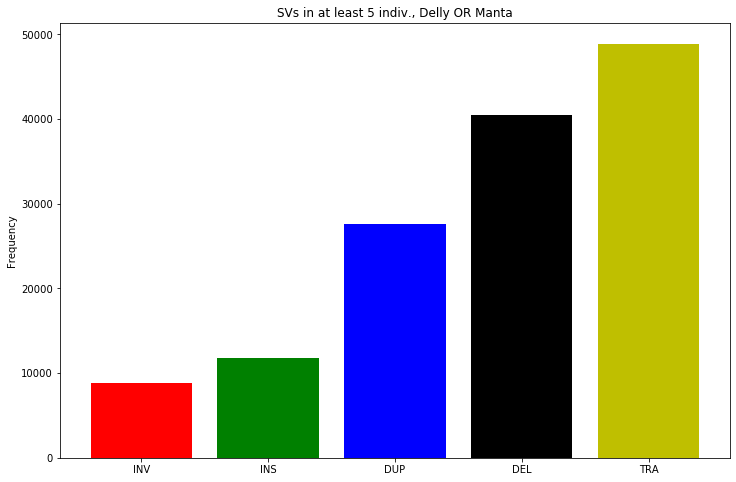

In [234]:
plt.rcParams['figure.figsize'] = [12, 8]
svtype, freq = zip(*sorted(Counter(unionCallset['SV type']).items(), key=lambda x:x[1]))
xpos = range(len(svtype))
plt.bar(xpos, (freq), align='center', color='rgbky')
plt.xticks(xpos, svtype)
plt.ylabel('Frequency')
plt.title('SVs in at least 5 indiv., Delly OR Manta')
freq

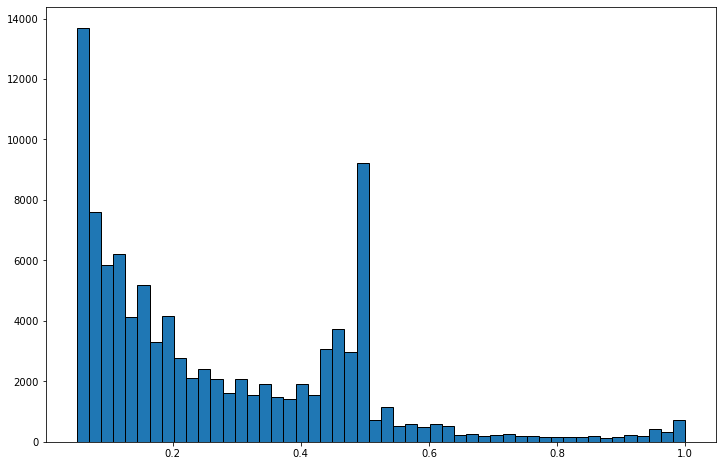

In [245]:
#insSV=unionCallset[unionCallset['SV type']=='INS']
#plt.hist(insSV['SV length'])
_=plt.hist(unionCallset.AF, bins=np.linspace(0.05, 1, 51), edgecolor='black')

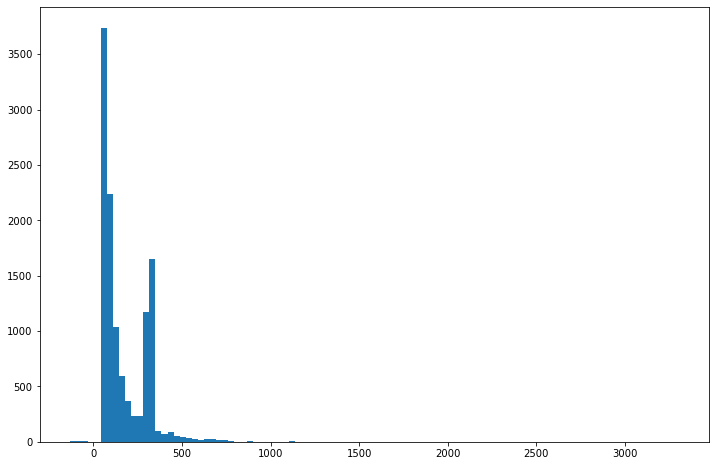

In [297]:
insSV=unionCallset[unionCallset['SV type']=='INS']
_ = plt.hist(insSV['SV length'], bins=100)

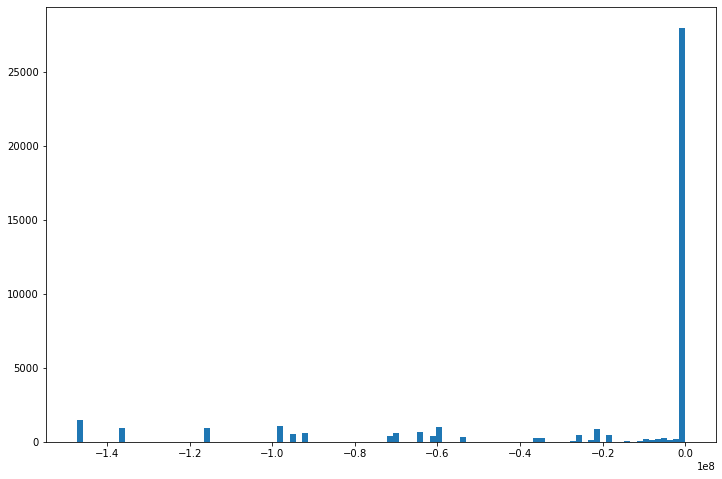

In [296]:
insSV=unionCallset[unionCallset['SV type']=='DEL']
_ = plt.hist(insSV['SV length'], bins=100)

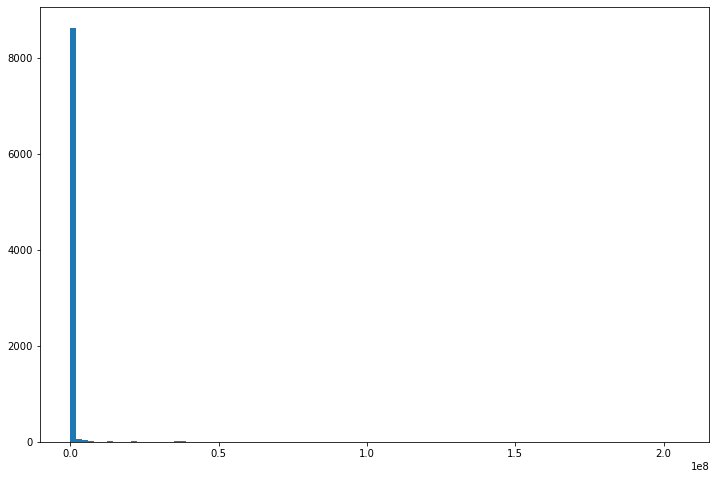

In [298]:
insSV=unionCallset[unionCallset['SV type']=='INV']
_ = plt.hist(insSV['SV length'], bins=100)

(array([12517.,   317.,   258.,   399.,   152.,   340.,     0.,     0.,
            0.,   124.,     0.,   733.,     0.,     0.,   654.,     0.,
            0.,     0.,     0.,   479.,   460.,   681.,     0.,   168.,
            0.,   580.,     0.,     0.,     0.,     0.,  1229.,     0.,
            0.,     0.,     0.,     0.,   418.,   536.,   678.,     0.,
          709.,     0.,     0.,     0.,     0.,     0.,   577.,     0.,
            0.,     0.,     0.,     0.,   716.,  1149.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   965.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  1394.,     0.,     0.,
            0.,     0.,     0.,  1387.]),
 array([5.20000000e+01, 1.95582635e+06, 3.91160070e+06, 5.86737505e+06,
        7.82314940e+06

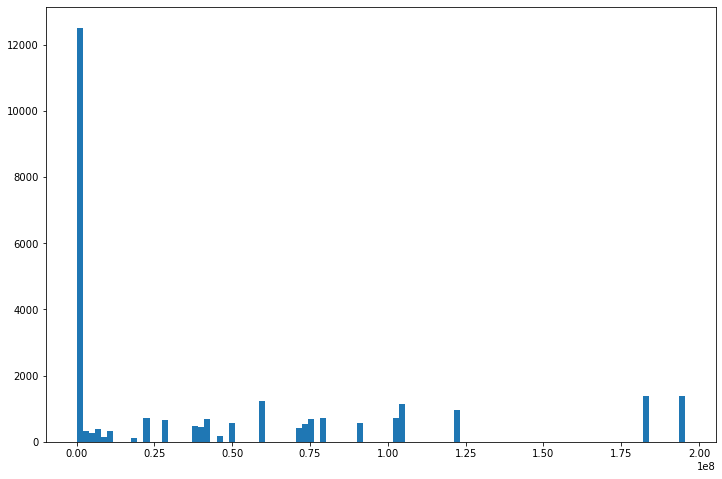

In [301]:
insSV=unionCallset[unionCallset['SV type']=='DUP']
plt.hist(insSV['SV length'], bins=100)

### Novel variants in union callset

In [263]:
novelUnion = unionCallset[unionCallset['GD_ID'].isnull()]
Counter(novelUnion['SV type'])

Counter({'TRA': 48902, 'DEL': 23897, 'INS': 11040, 'DUP': 17704, 'INV': 5755})

In [252]:
isecCallset5[isecCallset5['GD_ID'].isnull()].shape

(3527, 200)

In [255]:
isecCallset5.shape

(7149, 200)

In [257]:
df[df['GD_ID'].isnull()].shape

(916, 198)

In [259]:
df.shape

(1830, 198)

In [260]:
df[df['GD_ID'].isnull()]

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_mode,DDD_consequence,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking
7,1_14436308_14438241_DEL,1,14436308,14438241,-1929,DEL,MantaDEL:1349:1:2:0:0:0,C,<DEL>,999,PASS,SUPP=50;SUPP_VEC=10111010100111100100000001010...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"0/1:11:1900:0,0:+-:773:DEL:MantaDEL:1364:1:2:0...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:1933:0,0:+-:999:DEL:MantaDEL:1398:0:1:3...","1/1:11:1933:0,0:+-:999:DEL:MantaDEL:685:0:1:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
10,1_17684547_17685087_DEL,1,17684547,17685087,-479,DEL,DEL00000716,A,<DEL>,999,PASS,SUPP=53;SUPP_VEC=01101010100100110010011111100...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:479:0,0:+-:330:DEL:DEL00000716:NA:NA:ch...","0/1:11:479:0,0:+-:999:DEL:DEL00000716:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,79.64,0.495033,-0.735029,1.714341e-08,0.143032,-1.483231,-1.086506,NaN,yes,NaN,NaN,NaN,3
11,1_17684547_17685087_DEL,1,17684547,17685087,-479,DEL,DEL00000716,A,<DEL>,999,PASS,SUPP=53;SUPP_VEC=01101010100100110010011111100...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:479:0,0:+-:330:DEL:DEL00000716:NA:NA:ch...","0/1:11:479:0,0:+-:999:DEL:DEL00000716:NA:NA:ch...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,79.64,0.495033,-0.735029,1.714341e-08,0.143032,-1.483231,-1.086506,NaN,yes,605347,"(Rheumatoid arthritis, susceptibility to), 180...",NaN,3
12,1_21753997_21753998_INV,1,21753997,21753998,52558,INV,MantaBND:1856:0:1:0:0:0:0,C,[chr1:21806952[C,483,PASS,SUPP=71;SUPP_VEC=01110011110010010011110111001...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:52591:0,0:++:16:INV:MantaBND:1209:0:1:0...","0/1:11:52592:0,0:++:59:INV:MantaBND:2196:0:1:0...","0/1:11:52596:0,0:++:63:INV:MantaBND:1144:0:1:0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
15,1_25614291_25614292_INV,1,25614291,25614292,60760,INV,MantaBND:2160:0:2:0:0:0:0,C,CTATAGCTTAAGGACTCACCTGGCAGCAACACCAAACCAGGGCCAC...,999,PASS,SUPP=65;SUPP_VEC=01100100100101011001011110001...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:117802:0,0:++:12:INV:MantaBND:1408:0:1:...","0/1:11:58951:0,0:++:708:INV:MantaBND:2632:0:3:...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,83.71,0.651980,0.372818,2.013977e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1824,X_149571039_149571040_INV,X,149571039,149571040,14646,INV,MantaBND:185415:0:1:0:0:0:1,T,T]chrX:149585687],290,PASS,SUPP=89;SUPP_VEC=11011001111000111001010011111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"0/1:11:14647:0,0:++:58:INV:MantaBND:224557:0:1...","0/1:11:14647:0,0:++:89:INV:MantaBND:142473:0:1...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:14601:0,0:++:137:INV:MantaBND:129797:0:...",...,hemizygous,loss of function,X-LINKED HYPOSPADIAS TYPE 2,17086185,71.77,-1.101838,0.101399,8.058508e-01,NaN,NaN,NaN,yes,NaN,300120,"Hypospadias 2, XL, 300758 (3)",XLR,4
1825,Y_14172701_14172702_TRA,Y,14172701,14172702,0,TRA,MantaBND:204043:1:2:0:0:0:1,N,N[chrX:3196127[,999,PASS,SUPP=87;SUPP_VEC=00100111110111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","0/1:11:10976629:0,0:++:827:TRA:MantaBND:240272...","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1826,Y_16642969_16642970_TRA,Y,16642969,16642970,0,TRA,MantaBND:188682:2:3:0:0:0:1,N,N[chr

## Rare and Common Structural variants (AC>=1), confirmed by both Delly and Manta
After calling Delly and Manta SVs and merging with Survivor, we explore SVs (allele frequencies etc.) for 


The entire set of 10500 structural variants (detected by both Delly and Manta) give rise to 16395 annotations with AnnotSV. We focus on those that did not 

In [265]:
isecCallset1 = pd.read_csv('annotated_MantaDelly_1_2.tsv.gz', sep='\t')
isecCallset1.shape

/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,131,132,135,136,139,154,159,165,166,167,168,169,170,177,179,180,181,182,183,184,192,193,194,195,196) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(16395, 198)

In [267]:
isecCallset1['AC'], isecCallset1['AF'] = zip(*[allelFreq(row) for idx, row in isecCallset1.iterrows()]) # 
isecCallset1.sort_values(by=['AF'], ascending=False)  #sorting by allele frequency 

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_disease,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF
8623,2_208567051_208567555_DEL,2,208567051,208567555,-405,DEL,DEL00006757,C,<DEL>,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:744:DEL:DEL00006757:NA:NA:ch...","1/1:11:405:0,0:+-:999:DEL:DEL00006757:NA:NA:ch...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,232,1.0
847,1_224247102_224247578_DEL,1,224247102,224247578,-469,DEL,MantaDEL:7897:1:1:0:0:0,TTAAATTAAGGGCCTTAAAAAAAAAAAAAAAAAAAAAAGAGAGACA...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:469:0,0:+-:999:DEL:MantaDEL:15952:0:1:0...","1/1:11:469:0,0:+-:819:DEL:MantaDEL:9922:0:0:0:...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:17616:0:0:0...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:8971:0:1:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,232,1.0
15716,X_7623887_7673828_DEL,X,7623887,7673828,-49988,DEL,MantaDEL:204584:0:1:0:0:0,N,<DEL>,996,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:49978:0,0:+-:435:DEL:MantaDEL:216696:0:...","1/1:11:49979:0,0:+-:992:DEL:MantaDEL:137633:0:...","1/1:11:49968:0,0:+-:171:DEL:MantaDEL:240556:0:...","1/1:11:50019:0,0:+-:266:DEL:MantaDEL:125154:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,232,1.0
715,1_176478217_176478773_DEL,1,176478217,176478773,-539,DEL,MantaDEL:11882:0:1:0:0:0,TAAGTAGAGAATATGTGATGCACTATTTAATCAGAGGTCAGATGAG...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:539:0,0:+-:999:DEL:MantaDEL:12297:0:1:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:7624:0:0:0:...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:13595:0:0:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:6970:0:0:0:...",...,NaN,NaN,46.27,0.443411,0.299864,0.001084,-0.121360,1.453434,0.877118,NaN,NaN,NaN,NaN,NaN,1,232,1.0
714,1_176478217_176478773_DEL,1,176478217,176478773,-539,DEL,MantaDEL:11882:0:1:0:0:0,TAAGTAGAGAATATGTGATGCACTATTTAATCAGAGGTCAGATGAG...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:539:0,0:+-:999:DEL:MantaDEL:12297:0:1:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:7624:0:0:0:...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:13595:0:0:0...","1/1:11:539:0,0:+-:999:DEL:MantaDEL:6970:0:0:0:...",...,NaN,NaN,46.27,0.443411,0.299864,0.001084,-0.121360,1.453434,0.877118,NaN,NaN,NaN,NaN,NaN,1,232,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,10_25585589_25585590_TRA,10,25585589,25585590,0,TRA,MantaBND:9:1:3:0:0:0:0,N,N[chr1:569902[,355,PASS,SUPP=1;SUPP_VEC=000000000000000000000000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,41.52,0.748676,1.288718,0.361295,0.794495,0.625754,0.881376,NaN,NaN,NaN,NaN,NaN,2,0,0.0
1181,10_25585589_25585590_TRA,10,25585589,25585590,0,TRA,MantaBND:9:1:3:0:0:0:0,N,N[chr1:569902[,355,PASS,SUPP=1;SUPP_VEC=000000000000000000000000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,41.52,0.748676,1.288718,0.361295,0.794495,0.625754,0.881376,NaN,NaN,NaN,NaN,NaN,2,0,0.0
9351,21_18738478_18739336_DEL,21,18738478,18739336,-837,DEL,MantaDEL:190651:0:1:0:0:0,GGTGGCTCATGCCTGTAATCCC

### Novel structural variants in intersection call set

We here identify those SVs that are novel wrt. Gnomad-SV. We consider a variant novel, if its GD-ID annotation from AnnotSV is absent (`isecCallset1['GD_ID'].isnull()`).

In [289]:
## Novel structural variants
novelIsec = isecCallset1[isecCallset1['GD_ID'].isnull()] ## novel as per GnomadSV/AnnotSV
novelIsec['chrom'] = ['hs%s'%r['SV chrom'] for i,r in novelIsec.iterrows()]
novelIsec = novelIsec[novelIsec.AC>0] ## Survivor, why are there SVs with AC=0?
cols = 'chrom,SV start,SV end,AF'.split(',')
novelIsec[cols].to_csv('annotated_MantaDelly_1_2af.tsv',sep='\t',index=False,header=False)

/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(Still pipe outfile through uniq)

In [283]:
novelIsec[novelIsec.AC>0].sort_values(by='AF', ascending=False)

,AnnotSV ID,SV chrom,SV start,SV end,SV length,SV type,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10174,10187,10205,10215,...,DDD_pmids,HI_DDDpercent,synZ_ExAC,misZ_ExAC,pLI_ExAC,delZ_ExAC,dupZ_ExAC,cnvZ_ExAC,morbidGenes,morbidGenesCandidates,Mim Number,Phenotypes,Inheritance,AnnotSV ranking,AC,AF,chrom
847,1_224247102_224247578_DEL,1,224247102,224247578,-469,DEL,MantaDEL:7897:1:1:0:0:0,TTAAATTAAGGGCCTTAAAAAAAAAAAAAAAAAAAAAAGAGAGACA...,T,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:469:0,0:+-:999:DEL:MantaDEL:15952:0:1:0...","1/1:11:469:0,0:+-:819:DEL:MantaDEL:9922:0:0:0:...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:17616:0:0:0...","1/1:11:469:0,0:+-:999:DEL:MantaDEL:8971:0:1:0:...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,232,1.000000,chr1
1845,11_16587162_16587299_DEL,11,16587162,16587299,-136,DEL,MantaDEL:130066:0:0:0:0:0,GCATGGCACATGTATACATATGTAACTAACCTGCACAATGTGCACA...,GT,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:136:0,0:+-:888:DEL:MantaDEL:138543:0:1:...","1/1:11:136:0,0:+-:999:DEL:MantaDEL:88007:0:0:0...","1/1:11:136:0,0:+-:841:DEL:MantaDEL:12246:4:5:0...","1/1:11:136:0,0:+-:999:DEL:MantaDEL:79382:0:0:0...",...,NaN,0.59,-0.408155,1.824768,0.998643,0.384252,1.035932,0.890331,NaN,NaN,NaN,NaN,NaN,4,230,0.991379,chr11
1844,11_16587162_16587299_DEL,11,16587162,16587299,-136,DEL,MantaDEL:130066:0:0:0:0:0,GCATGGCACATGTATACATATGTAACTAACCTGCACAATGTGCACA...,GT,999,PASS,SUPP=117;SUPP_VEC=1111111111111111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:136:0,0:+-:888:DEL:MantaDEL:138543:0:1:...","1/1:11:136:0,0:+-:999:DEL:MantaDEL:88007:0:0:0...","1/1:11:136:0,0:+-:841:DEL:MantaDEL:12246:4:5:0...","1/1:11:136:0,0:+-:999:DEL:MantaDEL:79382:0:0:0...",...,NaN,0.59,-0.408155,1.824768,0.998643,0.384252,1.035932,0.890331,NaN,NaN,NaN,NaN,NaN,4,230,0.991379,chr11
15730,X_10738668_10788740_DEL,X,10738668,10788740,-50025,DEL,MantaDEL:234309:0:1:0:0:0,A,<DEL>,684,PASS,SUPP=115;SUPP_VEC=1111111111111101111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:50013:0,0:+-:326:DEL:MantaDEL:216958:0:...","1/1:11:50023:0,0:+-:684:DEL:MantaDEL:137728:0:...","1/1:11:50005:0,0:+-:296:DEL:MantaDEL:240677:0:...","1/1:11:50053:0,0:+-:396:DEL:MantaDEL:125284:0:...",...,NaN,5.13,0.270383,3.021392,0.773985,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,4,228,0.982759,chrX
10512,3_144517870_144518444_DEL,3,144517870,144518444,-550,DEL,MantaDEL:51730:0:0:0:1:0,CATATATATATATATATATATATATATATATATATATATATATATA...,C,999,PASS,SUPP=115;SUPP_VEC=1111011111011111111111111111...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"1/1:11:549:0,0:+-:339:DEL:MantaDEL:47710:0:1:0...","1/1:11:552:0,0:+-:537:DEL:MantaDEL:29740:0:0:0...","1/1:11:549:0,0:+-:831:DEL:MantaDEL:52819:0:0:0...","1/1:11:549:0,0:+-:556:DEL:MantaDEL:26787:0:0:0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,228,0.982759,chr3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9178,20_47596910_47596911_TRA,20,47596910,47596911,0,TRA,MantaBND:62001:0:1:0:0:0:1,N,N[chr5:10005263[,524,PASS,SUPP=1;SUPP_VEC=000000000000000000000000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,14647276,27.35,1.154112,3.005912,1.000000,-1.225734,0.604507,-0.102591,yes,NaN,605371,"Periventricular heterotopia with microcephaly,...",AR,4,1,0.004310,chr20
1947,11_37074597_37074598_TRA,11,37074597,37074598,0,TRA,MantaBND:80270:0:1:0:0:0:0,N,N[chr6:92065818[,24,PASS,SUPP=1;SUPP_VEC=000000000000000000000000000000...,GT:PSV:LN:DR:ST:QV:TY:ID:RAL:AAL:CO,"./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN","./.:NaN:0:0,0:--:NaN:NaN:NaN:NAN:NAN:NAN",...,NaN,NaN,NaN,NaN,NaN,NaN,N

In [288]:
novelIsec.shape

(8426, 201)

In [290]:
isecCallset1.shape

(16395, 200)

In [292]:
svType = 'DEL'
svTable = isecCallset1[isecCallset1['SV type']==svType]
sorted(svTable['SV length'])

[-997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -997094,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -996652,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -957508,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -917319,
 -884565,
 -884565,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -839875,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
 -823663,
